In [1]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
from jax import numpy as jnp
import jmp # jax mixed-precision
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
shd_dl = spyx.loaders.SHD_loader(256,128,128)

In [3]:
key = jax.random.PRNGKey(0)
x, y = shd_dl.train_epoch(key)

In [4]:
from spyx.experimental import StochasticAssociativeLIF

def shd_snn(x):
    k1, k2, k3 = jax.random.split(hk.next_rng_key(), 3)
    # We can use batch apply to apply the first linear layer across all of the input data
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    x, _ = StochasticAssociativeLIF((128,))(k1, x)
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    x, _ = StochasticAssociativeLIF((128,))(k2, x)
    x = hk.BatchApply(hk.Linear(20, with_bias=False))(x)
    spikes, V = StochasticAssociativeLIF((20,), spike=False)(k3, x)

    return spikes, V

In [5]:
# Create a random key
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.transform(shd_snn)
params = SNN.init(rng=key, x=jnp.float32(jnp.unpackbits(x[0], axis=1)))

In [6]:
def gd(SNN, params, epochs=300, lr=6e-4):
        
    opt = optax.chain(
        optax.centralize(),
        optax.adam(learning_rate=lr)
    )
    
    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params

    Loss = spyx.fn.integral_crossentropy()
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets, apply_key):
        readout = SNN.apply(weights, apply_key, events)
        spikes, V = readout
        return Loss(V, targets) # smoothing needs to be more explicit in docs...
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    rng = jax.random.PRNGKey(0)        
    
    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        grad_params, opt_state, batch_key = state
        batch_key, new_batch_key = jax.random.split(batch_key)
        events, targets = data # fix this
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient                    # need better augment rng
        loss, grads = surrogate_grad(grad_params, events, targets, new_batch_key)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state, batch_key]
        return new_state, loss
    
    
    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state, rng = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        net_key = jax.random.fold_in(shuffle_rng, epoch_num)

        train_data = shd_dl.train_epoch(shuffle_rng)
        
        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# func
            [curr_params, curr_opt_state, net_key],# init
            train_data,# xs
            train_data.obs.shape[0]# len
        )
                    
        return end_state, jnp.mean(train_loss)
    # end epoch
    
    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state, rng], # metric arrays
        jnp.arange(epochs), # 
        epochs # len of loop
    )
    
    final_params, _, _ = final_state
                
    # return our final, optimized network.       
    return final_params, metrics

In [7]:
def test_gd(SNN, params):

    Acc = spyx.fn.integral_accuracy()
    Loss = spyx.fn.integral_crossentropy()

    @jax.jit
    def test_step(test_state, data):
        params, batch_rng = test_state
        inference_rng, next_rng = jax.random.split(batch_rng)
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, inference_rng, events)
        traces, V = readout
        acc, pred = Acc(V, targets)
        loss = Loss(V, targets)
        return [params, next_rng], [acc, loss, pred, targets]
    
    test_data = shd_dl.test_epoch()
    rng_test = jax.random.PRNGKey(1)
    
    _, test_metrics = jax.lax.scan(
            test_step,# func
            [params, rng_test],# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )
    
    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts

In [8]:
grad_params, metrics = gd(SNN, params, epochs=300, lr=optax.linear_schedule(1e-3, 5e-5, 25*200))


  0%|          | 0/300 [00:00<?, ?it/s]

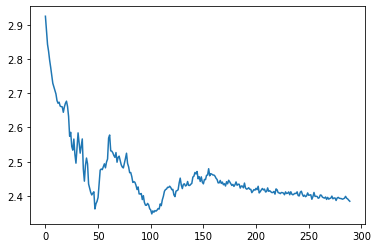

In [9]:
plt.plot(metrics[10:])

In [10]:
acc, loss, preds, tgts = test_gd(SNN, grad_params)
print("Accuracy:", acc, "Loss:", loss)

Accuracy: 0.44921875 Loss: 2.3762171


In [13]:
s2, v2 = SNN.apply(grad_params, jax.random.PRNGKey(4), jnp.unpackbits(x[0], 1))

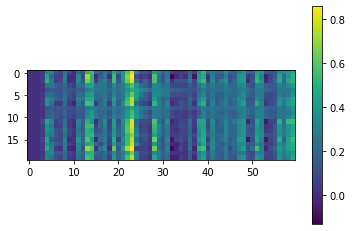

In [14]:
plt.imshow(s2[1, :60].T)
plt.colorbar()